This script aggregates the weather data into a single dataframe for us to use in forecast models

# Weather Data #

In [22]:
# imports
import pandas as pd
import numpy as np
import time

In [23]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

## Data Cleaning & Checking 

In [24]:
# weather data
temp_in = pd.read_excel(location+'Weather Data for Drexel 9_28_2018.xlsx', sheet_name="TMP")
humid_in = pd.read_excel(location+'Weather Data for Drexel 9_28_2018.xlsx', sheet_name="HUM")
wind_in = pd.read_excel(location+'Weather Data for Drexel 9_28_2018.xlsx', sheet_name="WSP")
cloud_in = pd.read_excel(location+'Weather Data for Drexel 9_28_2018.xlsx', sheet_name="CC")

In [25]:
# clean for hourly
hr_temp = temp_in.drop(columns=['Avg','HighDB','LowDB','AvgHL','Gas Day Average','HDD-HL','CDD-HL','HDD-24','CDD-24',
                            'Unnamed: 34','Unnamed: 35'])
hr_humid = humid_in.drop(columns=['Avg','Unnamed: 26','Unnamed: 27','Unnamed: 28'])
hr_wind = wind_in.drop(columns=['Avg','Unnamed: 26'])
hr_cloud = cloud_in.drop(columns=['AvgDaytime','Avg'])

# convert to datetime
hr_temp['Dt'] =  pd.to_datetime(hr_temp['Dt'])
hr_humid['Dt'] =  pd.to_datetime(hr_humid['Dt'])
hr_wind['Dt'] =  pd.to_datetime(hr_wind['Dt'])
hr_cloud['Dt'] =  pd.to_datetime(hr_cloud['Dt'])

In [26]:
# clean for daily
day_temp = temp_in.drop(columns=['HR0','HR1','HR2','HR3','HR4','HR5','HR6','HR7','HR8','HR9','HR10','HR11','HR12',
                             'HR13','HR14','HR15','HR16','HR17','HR18','HR19','HR20','HR21','HR22','HR23',
                             'AvgHL','Gas Day Average','HDD-HL','CDD-HL','HDD-24','CDD-24',
                             'Unnamed: 34','Unnamed: 35'])
day_temp = day_temp.rename(columns={'Avg':'AvgTemp'})

day_humid = humid_in.drop(columns=['HR0','HR1','HR2','HR3','HR4','HR5','HR6','HR7','HR8','HR9','HR10','HR11','HR12',
                               'HR13','HR14','HR15','HR16','HR17','HR18','HR19','HR20','HR21','HR22','HR23',
                               'Unnamed: 26','Unnamed: 27','Unnamed: 28'])
day_humid = day_humid.rename(columns={'Avg':'AvgHumid'})

day_wind = wind_in.drop(columns=['HR0','HR1','HR2','HR3','HR4','HR5','HR6','HR7','HR8','HR9','HR10','HR11','HR12',
                             'HR13','HR14','HR15','HR16','HR17','HR18','HR19','HR20','HR21','HR22','HR23',
                             'Unnamed: 26'])
day_wind = day_wind.rename(columns={'Avg':'AvgWind'})

day_cloud = cloud_in.drop(columns=['HR0','HR1','HR2','HR3','HR4','HR5','HR6','HR7','HR8','HR9','HR10','HR11','HR12',
                               'HR13','HR14','HR15','HR16','HR17','HR18','HR19','HR20','HR21','HR22','HR23'])
day_cloud = day_cloud.rename(columns={'AvgDaytime':'AvgDaytimeCloud', 'Avg':'AvgCloud'})

# convert to datetime
day_temp['Dt'] =  pd.to_datetime(day_temp['Dt'])
day_humid['Dt'] =  pd.to_datetime(day_humid['Dt'])
day_wind['Dt'] =  pd.to_datetime(day_wind['Dt'])
day_cloud['Dt'] =  pd.to_datetime(day_cloud['Dt'])

In [27]:
def lagDeltas(data, colname, newname, lag):
    """Calculates specified lag of provided column and saves as a new column
     
    Parameters
    ----------
    data : pandas dataframe object to be used calculate lag 0 and lag 1 deltas
    colname : name of column to be lagged
    newname : name of result to be added to pandas dataframe
    lag : number of lags to take 

    Returns
    ----------
    lagData : pandas dataframe with new column
    """
    
    data[newname] = data[colname].shift(lag)
    data[newname+'delta'] = data[colname]-data[newname]
    
    return data

## Daily Data Restructuring##

In [28]:
# sort by date
day_temp = day_temp.sort_values(by=["Dt"])
day_humid = day_humid.sort_values(by=["Dt"])
day_wind = day_wind.sort_values(by=["Dt"])
day_cloud = day_cloud.sort_values(by=["Dt"])

In [29]:
# Find lags of weather variables
# Lag temp
temp = lagDeltas(day_temp, "AvgTemp", "Temp1", 1)
temp = lagDeltas(temp, "HighDB", "HighDB1", 1)
temp = lagDeltas(temp, "LowDB", "LowDB1", 1)
humid = lagDeltas(day_humid, "AvgHumid", "Humid1", 1)
wind = lagDeltas(day_wind, "AvgWind", "Wind1", 1)
cloud = lagDeltas(day_cloud, "AvgCloud", "Cloud1", 1)

In [30]:
# Merge
weather1 = pd.merge(temp, humid, how='inner', on=['Dt'])
weather2 = pd.merge(wind, cloud, how='inner', on=['Dt'])
daily_weather = pd.merge(weather1, weather2, how='inner', on=['Dt'])

In [31]:
daily_weather.head()

,Dt,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,AvgHumid,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta
0,2000-01-01,37.000000,44,32,NaN,NaN,NaN,NaN,NaN,NaN,96.666667,NaN,NaN,3.083333,NaN,NaN,90.000000,87.791667,NaN,NaN
1,2000-01-02,51.250000,64,37,37.000000,14.250000,44.0,20.0,32.0,5.0,78.833333,96.666667,-17.833333,8.125000,3.083333,5.041667,93.333333,86.458333,87.791667,-1.333333
2,2000-01-03,57.583333,62,55,51.250000,6.333333,64.0,-2.0,37.0,18.0,82.541667,78.833333,3.708333,7.291667,8.125000,-0.833333,90.250000,80.708333,86.458333,-5.750000
3,2000-01-04,58.875000,67,49,57.583333,1.291667,62.0,5.0,55.0,-6.0,81.250000,82.541667,-1.291667,14.250000,7.291667,6.958333,100.000000,92.083333,80.708333,11.375000
4,2000-01-05,38.791667,47,32,58.875000,-20.083333,67.0,-20.0,49.0,-17.0,48.541667,81.250000,-32.708333,16.250000,14.250000,2.000000,10.833333,34.583333,92.083333,-57.500000


In [32]:
# add binary to identify cold days (<40 deg)
daily_weather['LT40'] = None
daily_weather.loc[ (daily_weather.AvgTemp <= 40), 'LT40'] = 1 

In [33]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
daily_weather.to_pickle(location+'daily_weather.pkl.zip')

## Hourly Data Restructuring ##

In [34]:
# Tidy / Stack data (transform into tall data - one row per customer per hour):
# ref: http://www.jeannicholashould.com/tidy-data-in-python.html
tidy_temp = pd.melt(hr_temp, 
                    id_vars=['Dt'],
                    var_name='Hour', value_name='Temp')

tidy_humid = pd.melt(hr_humid,
                     id_vars=['Dt'],
                     var_name='Hour', value_name='Humid')

tidy_wind = pd.melt(hr_wind, 
                    id_vars=['Dt'],
                    var_name='Hour', value_name='Wind')

tidy_cloud = pd.melt(hr_cloud, 
                     id_vars=['Dt'],
                     var_name='Hour', value_name='Cloud')

# relabel & retype for sorting
tidy_temp['Hour'] = tidy_temp['Hour'].str.extract('(\d+)').astype(int)
tidy_humid['Hour'] = tidy_humid['Hour'].str.extract('(\d+)').astype(int)
tidy_wind['Hour'] = tidy_wind['Hour'].str.extract('(\d+)').astype(int)
tidy_cloud['Hour'] = tidy_cloud['Hour'].str.extract('(\d+)').astype(int)

In [35]:
# sort by date & time
tidy_temp = tidy_temp.sort_values(by=["Dt","Hour"])
tidy_humid = tidy_humid.sort_values(by=["Dt","Hour"])
tidy_wind = tidy_wind.sort_values(by=["Dt","Hour"])
tidy_cloud = tidy_cloud.sort_values(by=["Dt","Hour"])

In [36]:
# Find lags of weather variables

# how many lags?
nlag = 6
# Lag temp
for i in range(1,nlag):
    temp = lagDeltas(tidy_temp, "Temp", "Temp"+str(i), i)

# Lag humid
for i in range(1,nlag):
    humid = lagDeltas(tidy_humid, "Humid", "Humid"+str(i), i)
    
# Lag wind
for i in range(1,nlag):
    wind = lagDeltas(tidy_wind, "Wind", "Wind"+str(i), i)

# Lag cloud
for i in range(1,nlag):
    cloud = lagDeltas(tidy_cloud, "Cloud", "Cloud"+str(i), i)


In [37]:
# Merge
weather1 = pd.merge(temp, humid, how='inner', on=['Dt','Hour'])
weather2 = pd.merge(wind, cloud, how='inner', on=['Dt','Hour'])
hourly_weather = pd.merge(weather1, weather2, how='inner', on=['Dt', 'Hour'])

In [38]:
# create single column for date and time
hourly_weather['year'] = pd.to_datetime(hourly_weather['Dt'].values).year
hourly_weather['month'] = pd.to_datetime(hourly_weather['Dt'].values).month
hourly_weather['day'] = pd.to_datetime(hourly_weather['Dt'].values).day
hourly_weather['datetime'] = pd.to_datetime(hourly_weather[['year','month','day','Hour']])

# sort by date & time
hourly_weather = hourly_weather.drop(columns=['Dt','year','month','day','Hour'])
hourly_weather = hourly_weather.sort_values(by=['datetime'])
hourly_weather = hourly_weather.rename(columns={'datetime':'Dt'}) # for consistency

In [39]:
hourly_weather.head()

,Temp,Temp1,Temp1delta,Temp2,Temp2delta,Temp3,Temp3delta,Temp4,Temp4delta,Temp5,...,Cloud1delta,Cloud2,Cloud2delta,Cloud3,Cloud3delta,Cloud4,Cloud4delta,Cloud5,Cloud5delta,Dt
0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 00:00:00
1,37.0,35.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 01:00:00
2,37.0,37.0,0.0,35.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 02:00:00
3,35.0,37.0,-2.0,37.0,-2.0,35.0,0.0,NaN,NaN,NaN,...,0.0,100.0,0.0,100.0,0.0,NaN,NaN,NaN,NaN,2000-01-01 03:00:00
4,33.0,35.0,-2.0,37.0,-4.0,37.0,-4.0,35.0,-2.0,NaN,...,0.0,100.0,0.0,100.0,0.0,100.0,0.0,NaN,NaN,2000-01-01 04:00:00


In [40]:
# add binary to identify hours days (<40 deg)
hourly_weather['LT40'] = None
hourly_weather.loc[ (hourly_weather.Temp <= 40), 'LT40'] = 1 

In [41]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
hourly_weather.to_pickle(location+'hourly_weather.pkl.zip')

## Visualize ##

In [41]:
list(hourly_weather)

['Temp',
 'Temp1',
 'Temp1delta',
 'Temp2',
 'Temp2delta',
 'Humid',
 'Humid1',
 'Humid1delta',
 'Humid2',
 'Humid2delta',
 'Wind',
 'Wind1',
 'Wind1delta',
 'Wind2',
 'Wind2delta',
 'Cloud',
 'Cloud1',
 'Cloud1delta',
 'Cloud2',
 'Cloud2delta',
 'Dt']

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

A = pd.merge(tidy_temp, tidy_humid, how='inner', on=['Dt','Hour'])
B = pd.merge(tidy_wind, tidy_cloud, how='inner', on=['Dt','Hour'])
pcaData = pd.merge(A, B, how='inner', on=['Dt', 'Hour'])
# PCA
pca = decomposition.PCA(n_components=4,whiten=True)
X = pca.fit_transform(hourly_weather[['Temp','Humid','Wind','Cloud']].dropna())

print("PCA % Variance Explained:\n{}:".format(pca.explained_variance_ratio_))
# print(pca.explained_variance_)
# print("PCA Components:\n{}:".format(pca.components_))

PCA % Variance Explained:
[0.70053584 0.14592523 0.1428353  0.01070363]:


Text(0, 0.5, 'Principal Components')

<Figure size 720x720 with 0 Axes>

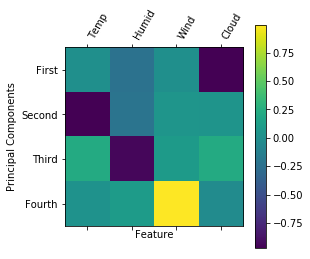

In [48]:
# visualize pcas
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(10,10))
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1,2,3], ['First','Second','Third','Fourth'])
plt.colorbar()
plt.xticks(range(len(list(hourly_weather[['Temp','Humid','Wind','Cloud']]))),
           list(hourly_weather[['Temp','Humid','Wind','Cloud']]), rotation = 60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal Components')

## Merge with Use ##

In [ ]:
# daily load data
daily = pd.read_pickle(location+'peco_daily.pkl.zip')
sufficient_daily = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
weather = pd.read_pickle(location+'daily_weather.pkl.zip')

# merge
daily = pd.merge(daily, weather, how='inner', on=['Dt'])
sufficient_daily = pd.merge(sufficient_daily, weather, how='inner', on=['Dt'])

# load hourly data
hourly = pd.read_pickle(location+'peco_hourly.pkl.zip')
sufficient_hourly = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
weather = pd.read_pickle(location+'hourly_weather.pkl.zip')

# merge
hourly = pd.merge(hourly, weather, how='inner', on=['Dt'])
sufficient_hourly = pd.merge(sufficient_hourly, weather, how='inner', on=['Dt'])
# CustIDs || Date | Consumption |||| Weather_variables 